In [1]:
from typing import List, Optional
from tqdm import tqdm
import time


import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp


from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import lightgbm as lgbm


import statsmodels.api as sm
import shap

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Оглавление

* <a href='#link_01'>1. Считывание данных, обзор данных и базовых статистик </a>
* <a href='#link_02'>2. Графики распределения для категориальных признаков</a>
* <a href='#link_03'>3. Графики распределения для непрерывных признаков </a>
* <a href='#link_04'>4. Анализ пропусков </a>
* <a href='#link_05'>5. Корреляция между числовыми признаками </a>
* <a href='#link_06'>6. Анализ распределения на обучении и тесте </a>
* <a href='#link_07'>7. Генерация признаков </a>
* <a href='#link_08'>8. обучение моделей </a>
* <a href='#link_09'>8.1 Обучение модели для предказания target1 </a>
* <a href='#link_10'>8.2 Обучение модели для предказания target2 </a>
* <a href='#link_11'>8.3 Обучение модели для предказания target3 </a>
* <a href='#link_12'>8.4 Обучение модели для предказания target4 </a>
 













In [2]:
def type_selector(df: pd.DataFrame) -> list:

    """
   
    Разбиение признаков на типы , 
    в continuous_columns передаюся непрерывные признаки с типом данных np.number,
    в categorical_columns передаются признаки с типом данных object и признаки из
    continuous_columns в которых колличество уникальных значений ниже определенного порога
    
    ---------------------------------------------------------------------------------------
    Returns
        -------
    categorical_columns: list
        список категориальных признаков
    continuous_columns: list
        список непрерывных признаков
    
    """
    continuous_columns = df.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(df[feature].unique()) < 40 # Указываем колличество уникальных значений в признаке 
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    return categorical_columns, continuous_columns

In [3]:
def time_feature(df: pd.DataFrame) -> pd.DataFrame :
    
    """
    Перевод признака Unnamed: 0 к типу данных pd.to_datetime,
    далее добавление в датасет признаков на основе времени,
    year(int) год,
    month_of_year(int) месяц года,
    day_of_month(int) день месяца,
    day_of_week(int) день недели,
    hour_of_day(int) час дня
    ---------------------------------------------------------------------------------------
    Return
        ---------
    pd.DataFrame с признаками на основе времени
    
    """
    df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
    
    df["year"] = df["Unnamed: 0"].dt.year
    df["month_of_year"] = df["Unnamed: 0"].dt.month
    df["day_of_month"] = df["Unnamed: 0"].dt.day
    df["day_of_week"] = df["Unnamed: 0"].dt.weekday
    df["hour_of_day"] = df["Unnamed: 0"].dt.hour
    
    return df

<a id='link_01'></a>
1. Считывание данных, обзор данных и базовых статистик

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(F'Размерность train {train.shape[0]} наблюдений и {train.shape[1]} признаков')
print(F'Размерность test {test.shape[0]} наблюдений и {test.shape[1]} признаков')

Размерность train 200000 наблюдений и 84 признаков
Размерность test 100000 наблюдений и 80 признаков


In [5]:
train.head()

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,...,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,...,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test.head()

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
0,2017-01-03 21:21:00,12.59972,NaN,NaN,NaN,NaN,NaN,45.27993,43.13644,NaN,...,37.63644,40.64410,53.44470,NaN,36.59567,64.47523,45.08920,NaN,NaN,NaN
1,2017-01-03 21:22:00,12.65850,NaN,NaN,NaN,NaN,NaN,NaN,42.98455,NaN,...,37.69201,40.68030,53.43953,NaN,36.60715,64.48697,45.18127,NaN,NaN,NaN
2,2017-01-03 21:23:00,12.69538,NaN,NaN,NaN,NaN,NaN,NaN,41.87401,NaN,...,37.71147,40.69286,53.42733,NaN,36.60194,64.48034,45.00529,75.84169,NaN,NaN
3,2017-01-03 21:24:00,12.84726,NaN,NaN,NaN,NaN,NaN,NaN,41.78006,NaN,...,37.70427,40.61716,53.44097,NaN,36.61879,64.50220,45.10987,NaN,93.62097,NaN
4,2017-01-03 21:25:00,12.98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.69343,40.64507,53.51237,NaN,36.59875,64.48300,45.12246,NaN,NaN,56.14647


In [7]:
train.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
count,1.999340e+05,109370.000000,109456.000000,85.000000,9736.000000,373.000000,88122.000000,16777.000000,407.000000,199837.000000,...,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,1.471747e+01,0.003483,12.696579,9.101270,31.654650,68.328355,47.680708,46.703799,71.668521,23.584873,...,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,0.001156,0.049836,0.942428,0.006580
std,1.873427e+00,0.017229,4.285856,9.667475,5.039073,13.580792,4.506643,3.940905,0.606023,4.877921,...,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,0.000085,0.003685,0.003936,0.001442
min,2.215690e-08,-0.005142,0.008831,-3.354573,15.898870,10.271640,22.730830,24.820300,69.825200,8.848302,...,23.078610,62.552550,44.860980,71.780270,90.015210,46.590670,0.000826,0.035611,0.912861,0.002595
25%,1.359252e+01,0.001326,8.111923,4.375712,28.884520,71.918530,45.656210,44.315390,71.271280,19.473280,...,35.693970,66.247250,52.843030,75.441780,93.305450,54.954120,0.001101,0.047461,0.940184,0.005565
50%,1.494062e+01,0.003691,14.088605,9.799968,30.903065,72.293790,47.029165,46.293030,71.680350,24.987920,...,40.920650,66.503290,53.638400,75.831920,94.044160,55.834110,0.001155,0.049773,0.942605,0.006435
75%,1.596708e+01,0.005223,16.081407,9.804002,33.087140,72.644420,48.534740,48.446820,72.021965,27.450710,...,49.107915,66.792830,55.264280,76.018390,95.407530,57.059038,0.001206,0.051962,0.945057,0.007307
max,2.201591e+01,3.886294,22.935910,59.259140,60.604910,75.945500,81.115520,71.128090,74.078940,33.632790,...,57.003070,68.679210,58.624550,77.190620,112.647200,60.550670,0.001865,0.080406,0.956497,0.014346


In [8]:
test.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
count,99828.000000,0.0,0.0,78.000000,14939.000000,253.000000,15075.000000,22888.000000,94.000000,99828.000000,...,99828.000000,99828.000000,99828.000000,1689.000000,99828.000000,99828.000000,99828.000000,25134.000000,25062.000000,89034.000000
mean,11.301044,NaN,NaN,8.259843,41.407615,74.353744,48.562236,47.011030,72.535830,28.243433,...,37.375712,48.518393,52.715619,72.800997,35.870347,66.238411,52.266307,76.145161,93.546410,56.186307
std,0.984816,NaN,NaN,3.282814,3.911453,1.140371,1.741324,3.647882,1.719166,1.829707,...,5.049837,0.738174,3.040632,0.124691,4.968143,0.296024,0.680044,0.269156,1.104953,0.962682
min,3.220560,NaN,NaN,0.012514,1.963458,70.963010,39.741910,-5.701760,68.854050,17.935470,...,21.145900,40.576020,37.517330,71.772730,20.574680,64.475230,44.986940,74.598110,89.532410,45.591770
25%,10.693297,NaN,NaN,8.984852,38.639195,73.982380,47.806935,45.012725,71.475152,27.018318,...,33.858123,48.077060,50.832770,72.719760,32.416390,66.042010,51.840950,75.951777,92.870402,55.734475
50%,11.219690,NaN,NaN,9.456869,42.063110,74.526950,48.434970,46.962850,73.077210,28.180595,...,37.569050,48.417800,53.114740,72.804590,36.149480,66.223210,52.195340,76.177615,93.391165,56.227965
75%,11.815215,NaN,NaN,9.798799,44.507690,75.287080,49.070015,48.647073,73.387382,29.367270,...,41.254337,48.862290,54.984330,72.884380,39.572348,66.410790,52.620430,76.319505,94.122135,56.714360
max,15.286960,NaN,NaN,15.827820,57.351200,75.861770,69.288530,71.717910,76.056930,38.283100,...,48.155980,50.847430,58.595240,73.244420,45.905800,68.074200,54.611230,83.859830,110.095000,61.964800


##### При обзоре данных и базовых статистик :
    * признаки анонимизированны и имеют названия tag1-tag79 
    * признак Unnamed: 0 содержит время 
    * имеются пропуски
    * имеется 4 целевых переменных
    * в целевых переменных имеются пропуски

Использовав функцию time_feature добавим в датасеты признаки на основе времени(Год, месяц, день месяца, день недели, час дня )

In [9]:
time_feature(train)

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag79,target1,target2,target3,target4,year,month_of_year,day_of_month,day_of_week,hour_of_day
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,8,18,3,0
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,8,18,3,0
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.07365,NaN,NaN,NaN,NaN,2016,8,18,3,0
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,8,18,3,0
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,8,18,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2017-01-03 21:15:00,12.59146,NaN,NaN,NaN,49.92619,NaN,NaN,42.96059,NaN,...,NaN,0.001514,0.065270,0.928968,0.004248,2017,1,3,1,21
199996,2017-01-03 21:16:00,12.66785,NaN,NaN,NaN,NaN,NaN,45.13568,42.03654,NaN,...,56.31732,0.001514,0.065273,0.928968,0.004245,2017,1,3,1,21
199997,2017-01-03 21:17:00,12.74665,NaN,NaN,NaN,NaN,NaN,NaN,41.70169,NaN,...,NaN,0.001516,0.065336,0.928906,0.004242,2017,1,3,1,21
199998,2017-01-03 21:18:00,12.91019,NaN,NaN,NaN,NaN,NaN,44.72477,42.94123,NaN,...,NaN,0.001516,0.065333,0.928912,0.004239,2017,1,3,1,21


In [10]:
time_feature(test)

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag75,tag76,tag77,tag78,tag79,year,month_of_year,day_of_month,day_of_week,hour_of_day
0,2017-01-03 21:21:00,12.59972,NaN,NaN,NaN,NaN,NaN,45.27993,43.13644,NaN,...,64.47523,45.08920,NaN,NaN,NaN,2017,1,3,1,21
1,2017-01-03 21:22:00,12.65850,NaN,NaN,NaN,NaN,NaN,NaN,42.98455,NaN,...,64.48697,45.18127,NaN,NaN,NaN,2017,1,3,1,21
2,2017-01-03 21:23:00,12.69538,NaN,NaN,NaN,NaN,NaN,NaN,41.87401,NaN,...,64.48034,45.00529,75.84169,NaN,NaN,2017,1,3,1,21
3,2017-01-03 21:24:00,12.84726,NaN,NaN,NaN,NaN,NaN,NaN,41.78006,NaN,...,64.50220,45.10987,NaN,93.62097,NaN,2017,1,3,1,21
4,2017-01-03 21:25:00,12.98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.48300,45.12246,NaN,NaN,56.14647,2017,1,3,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2017-03-14 07:56:00,12.08330,NaN,NaN,NaN,44.63140,NaN,NaN,NaN,NaN,...,66.08608,53.43510,75.92390,NaN,55.59630,2017,3,14,1,7
99996,2017-03-14 07:57:00,12.13475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.09002,53.44431,NaN,NaN,55.64390,2017,3,14,1,7
99997,2017-03-14 07:58:00,12.18710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.11372,53.40477,NaN,103.04540,55.63939,2017,3,14,1,7
99998,2017-03-14 07:59:00,12.25297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.10795,53.46239,NaN,NaN,55.59716,2017,3,14,1,7


Применив функцию type_selector разделим признаки на категориальные и непрерывные убрав целевые переменные и Unnamed: 0


In [11]:
categorical_columns, continuous_columns = type_selector(train.drop(['target1', 'target2', 'target3', 'target4', 'Unnamed: 0'], 1))
continuous_columns.sort()

Посмотрим базовые статистики для категориальных переменных

In [12]:
train[categorical_columns].describe()

,tag46,year,month_of_year,day_of_month,day_of_week,hour_of_day
count,98410.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.0,2016.020800,10.057600,16.348800,3.008800,11.491500
std,0.0,0.142715,1.846483,9.005351,2.005378,6.918408
min,0.0,2016.000000,1.000000,1.000000,0.000000,0.000000
25%,0.0,2016.000000,9.000000,8.000000,1.000000,5.000000
50%,0.0,2016.000000,10.000000,17.000000,3.000000,11.000000
75%,0.0,2016.000000,11.000000,24.000000,5.000000,17.000000
max,0.0,2017.000000,12.000000,31.000000,6.000000,23.000000


In [13]:
test[categorical_columns].describe()

,tag46,year,month_of_year,day_of_month,day_of_week,hour_of_day
count,99828.0,100000.0,100000.000000,100000.00000,100000.000000,100000.000000
mean,0.0,2017.0,1.787220,14.28491,3.016000,11.478470
std,0.0,0.0,0.742651,8.34045,1.999946,6.937091
min,0.0,2017.0,1.000000,1.00000,0.000000,0.000000
25%,0.0,2017.0,1.000000,7.00000,1.000000,5.000000
50%,0.0,2017.0,2.000000,13.00000,3.000000,11.000000
75%,0.0,2017.0,2.000000,21.00000,5.000000,17.000000
max,0.0,2017.0,3.000000,31.00000,6.000000,23.000000


признак tag46 выглядит очень странно , нужно просмотреть его отдельно , в трейне данные за 2016-2017 в тесте только 2017 год

In [14]:
train[continuous_columns].describe()

,tag1,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,...,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,tag8,tag9
count,1.999340e+05,199837.000000,199867.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,...,199867.000000,35087.000000,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,16777.000000,407.000000
mean,1.471747e+01,23.584873,50.128928,-0.000334,0.009145,-0.001012,0.000952,0.000641,0.000594,0.001458,...,56.016110,72.578699,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,46.703799,71.668521
std,1.873427e+00,4.877921,16.948128,0.002746,0.006391,0.000964,0.000167,0.000156,0.000138,0.000478,...,4.041327,0.235175,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,3.940905,0.606023
min,2.215690e-08,8.848302,-0.050376,-0.030081,-0.003332,-0.002694,0.000252,0.000161,0.000170,0.000683,...,43.124100,67.901700,23.078610,62.552550,44.860980,71.780270,90.015210,46.590670,24.820300,69.825200
25%,1.359252e+01,19.473280,34.921825,-0.000335,0.004831,-0.002235,0.000843,0.000526,0.000491,0.001129,...,52.935380,72.457090,35.693970,66.247250,52.843030,75.441780,93.305450,54.954120,44.315390,71.271280
50%,1.494062e+01,24.987920,56.727810,0.000118,0.008843,-0.000377,0.000993,0.000610,0.000579,0.001406,...,55.919250,72.586170,40.920650,66.503290,53.638400,75.831920,94.044160,55.834110,46.293030,71.680350
75%,1.596708e+01,27.450710,62.649445,0.000260,0.014776,-0.000219,0.001088,0.000761,0.000693,0.001696,...,59.685215,72.738400,49.107915,66.792830,55.264280,76.018390,95.407530,57.059038,48.446820,72.021965
max,2.201591e+01,33.632790,83.262920,0.108213,0.022987,0.009974,0.001305,0.001309,0.001229,0.041821,...,65.125020,73.605550,57.003070,68.679210,58.624550,77.190620,112.647200,60.550670,71.128090,74.078940


In [15]:
test[continuous_columns].describe()

,tag1,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,...,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,tag8,tag9
count,99828.000000,99828.000000,99828.000000,99833.000000,99836.000000,99836.000000,99836.000000,99827.000000,99836.000000,99836.000000,...,99828.000000,1689.000000,99828.000000,99828.000000,99828.000000,25134.000000,25062.000000,89034.000000,22888.000000,94.000000
mean,11.301044,28.243433,23.157935,-0.000365,0.004475,-0.002460,0.001000,0.000469,0.000385,0.001581,...,52.715619,72.800997,35.870347,66.238411,52.266307,76.145161,93.546410,56.186307,47.011030,72.535830
std,0.984816,1.829707,6.774595,0.001169,0.003759,0.000086,0.000091,0.000218,0.000056,0.000284,...,3.040632,0.124691,4.968143,0.296024,0.680044,0.269156,1.104953,0.962682,3.647882,1.719166
min,3.220560,17.935470,-0.041168,-0.014142,-0.003333,-0.002742,0.000522,-0.000305,0.000241,0.001012,...,37.517330,71.772730,20.574680,64.475230,44.986940,74.598110,89.532410,45.591770,-5.701760,68.854050
25%,10.693297,27.018318,17.973670,-0.000090,0.002213,-0.002523,0.000957,0.000383,0.000346,0.001344,...,50.832770,72.719760,32.416390,66.042010,51.840950,75.951777,92.870402,55.734475,45.012725,71.475152
50%,11.219690,28.180595,23.626520,0.000165,0.004791,-0.002476,0.001016,0.000423,0.000379,0.001560,...,53.114740,72.804590,36.149480,66.223210,52.195340,76.177615,93.391165,56.227965,46.962850,73.077210
75%,11.815215,29.367270,28.537105,0.000295,0.007349,-0.002380,0.001062,0.000477,0.000417,0.001746,...,54.984330,72.884380,39.572348,66.410790,52.620430,76.319505,94.122135,56.714360,48.647073,73.387382
max,15.286960,38.283100,44.218840,0.031430,0.013001,-0.002142,0.001256,0.002617,0.000708,0.002426,...,58.595240,73.244420,45.905800,68.074200,54.611230,83.859830,110.095000,61.964800,71.717910,76.056930


<a id='link_02'></a>
2. Построим графики распределения для категориальных признаков 

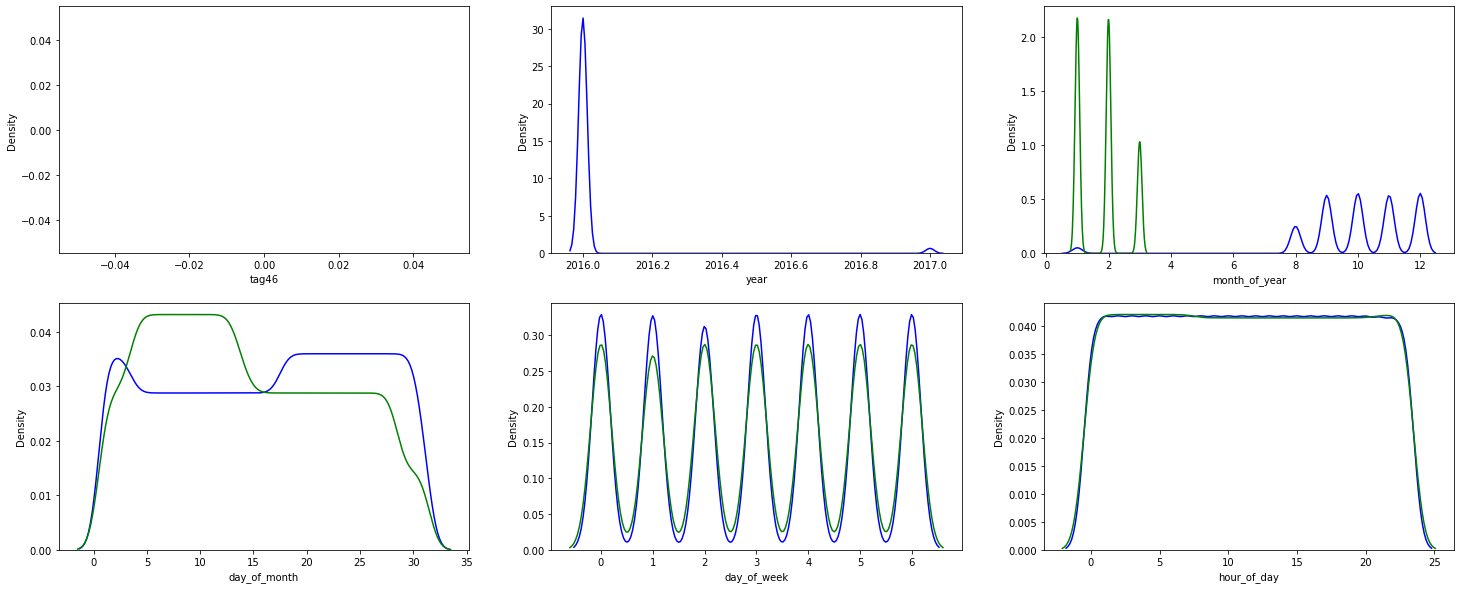

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(25, 10))

for num, feature in enumerate(categorical_columns):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")

* tag46 как и ожидалось пустой признак его можно удалить
* данные за разные временные промежутки (год, месяц)
* стоит убрать признак tag46 из train и test выборок

Применив функцию type_selector разобьем данные на категориальные и непрерывные и построим графики распределений непрерывных переменных

<a id='link_03'></a>
3. Построим графики распределения для непрерывных признаков

In [17]:
train = train.drop(['tag46','year','month_of_year'],1)
test = test.drop(['tag46','year','month_of_year'],1)
categorical_columns, continuous_columns = type_selector(train.drop(['target1', 'target2', 'target3', 'target4', 'Unnamed: 0'], 1))
continuous_columns.sort()

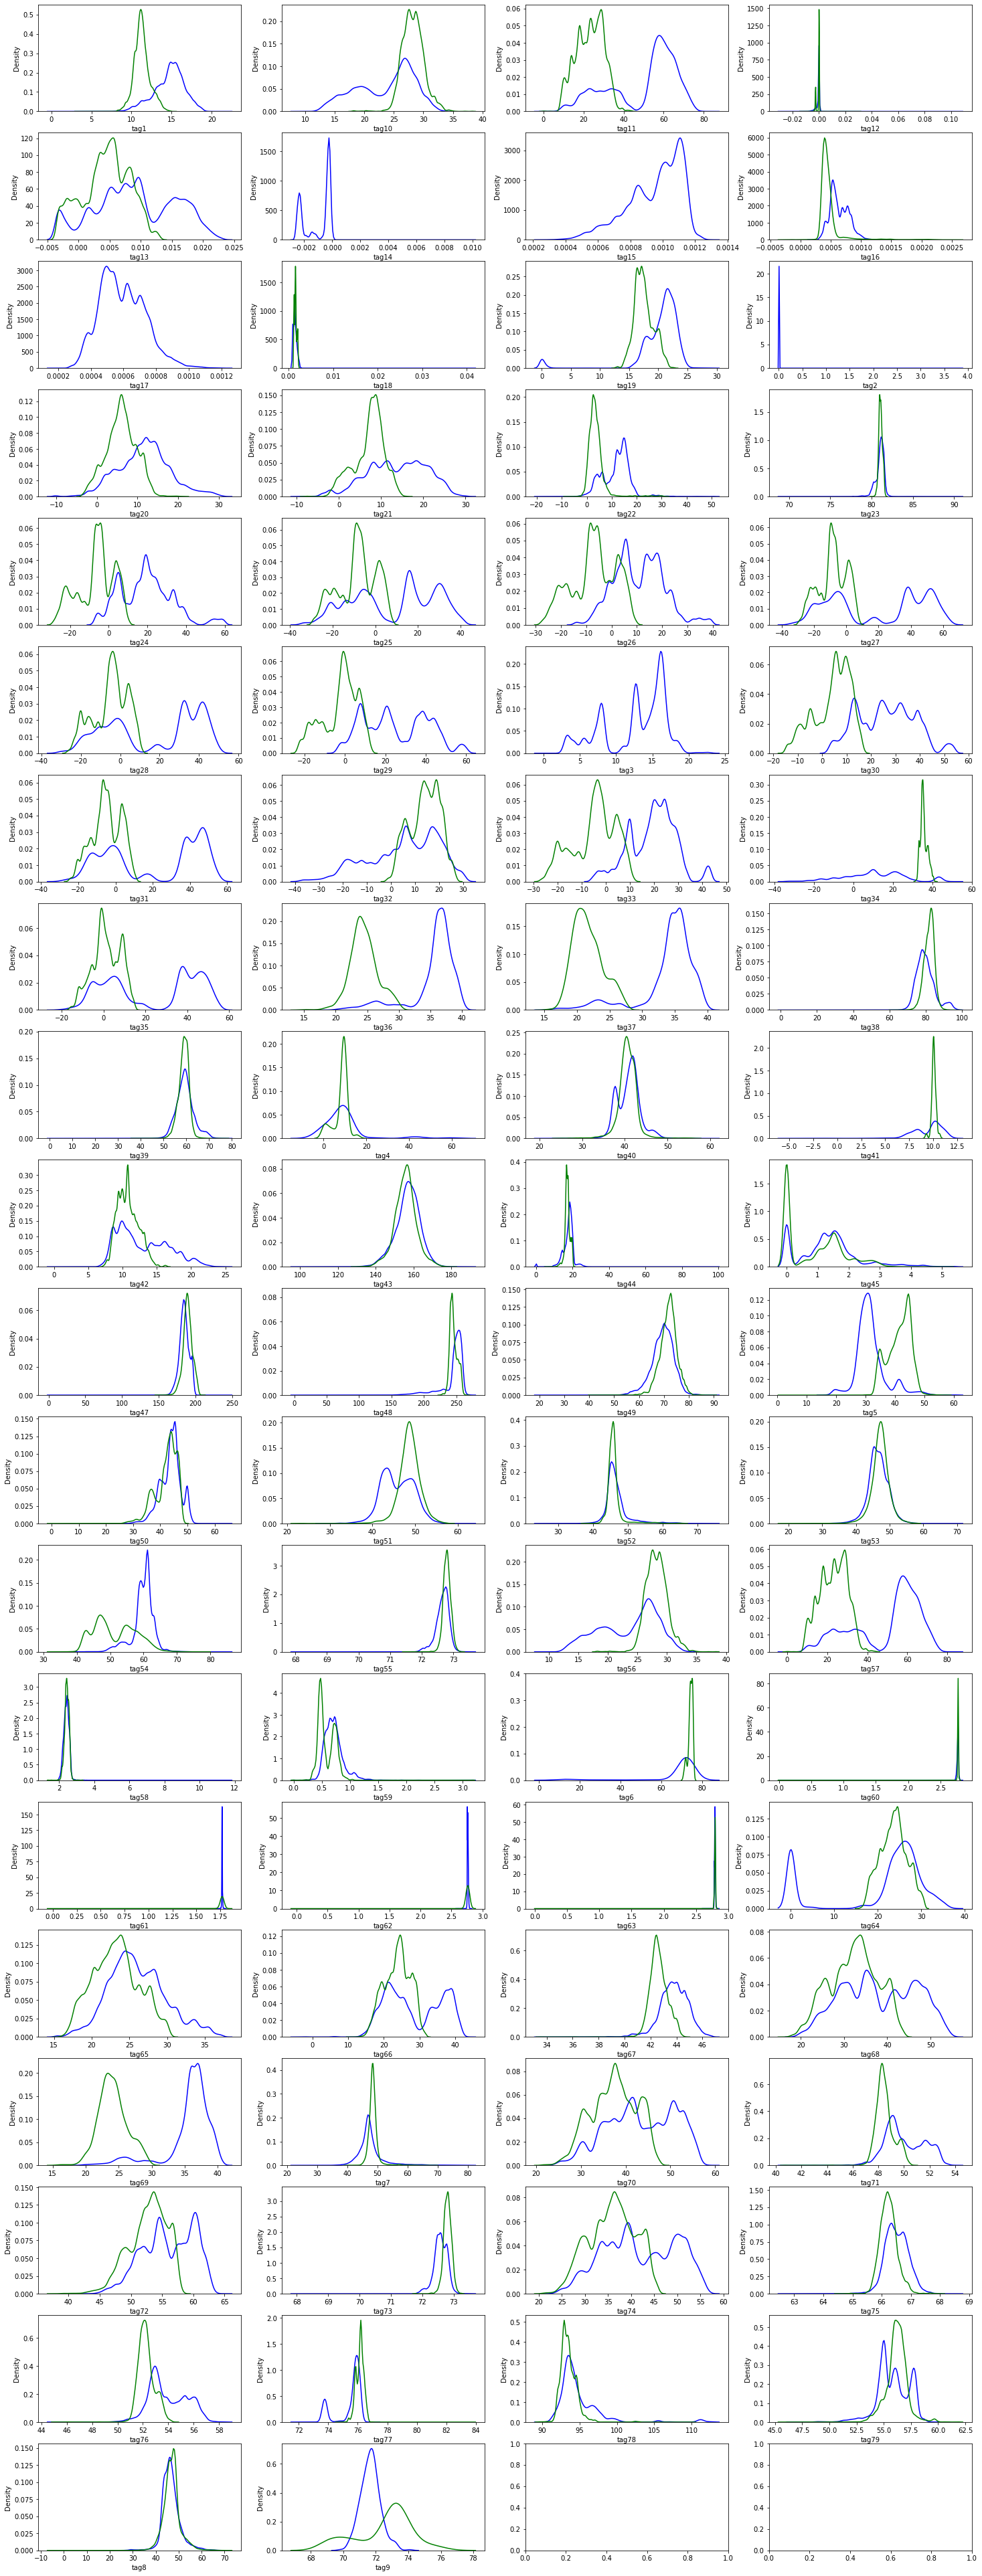

In [18]:
fig, axes = plt.subplots(20, 4, figsize=(25, 70))

for num, feature in enumerate(continuous_columns):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")

* распределения большинства признаков очень отличаются
* так же есть признаки в которых имеются наблюдения только в трейне

<a id='link_04'></a>
4. Анализ пропусков

Использовав библиотеку missingno напропуски в данных

<AxesSubplot:>

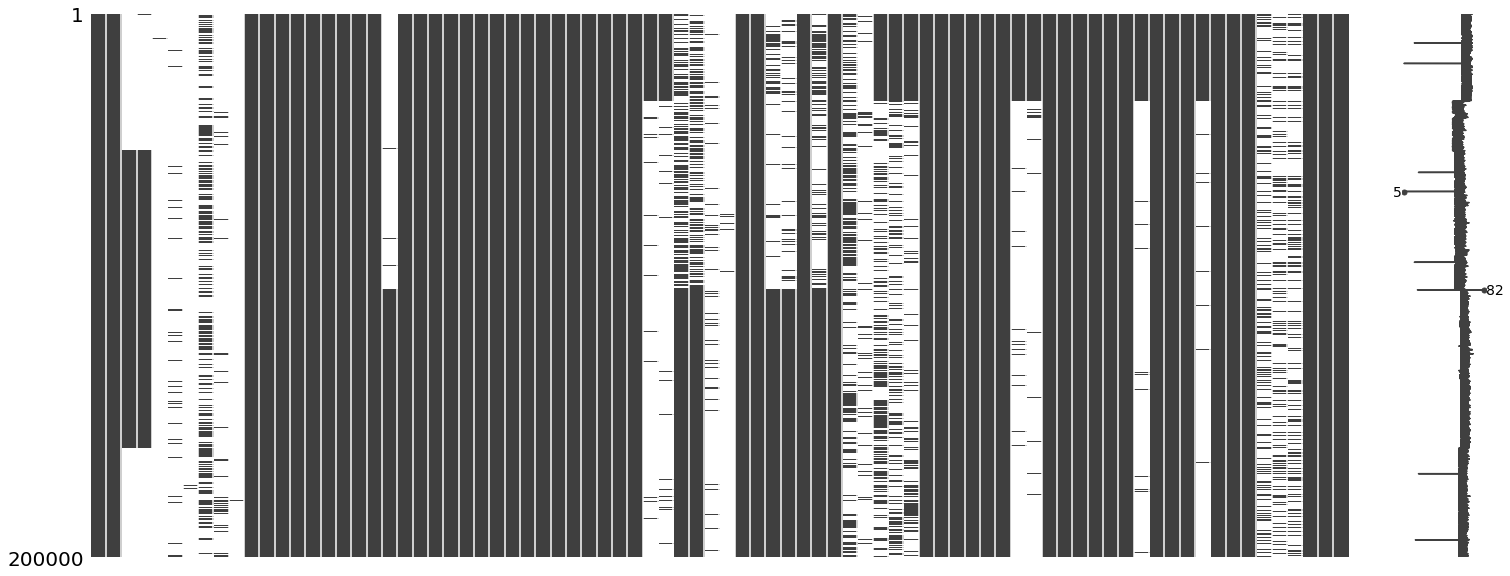

In [19]:
msno.matrix(train.drop(['target1','target2', 'target3','target4'],1))

<AxesSubplot:>

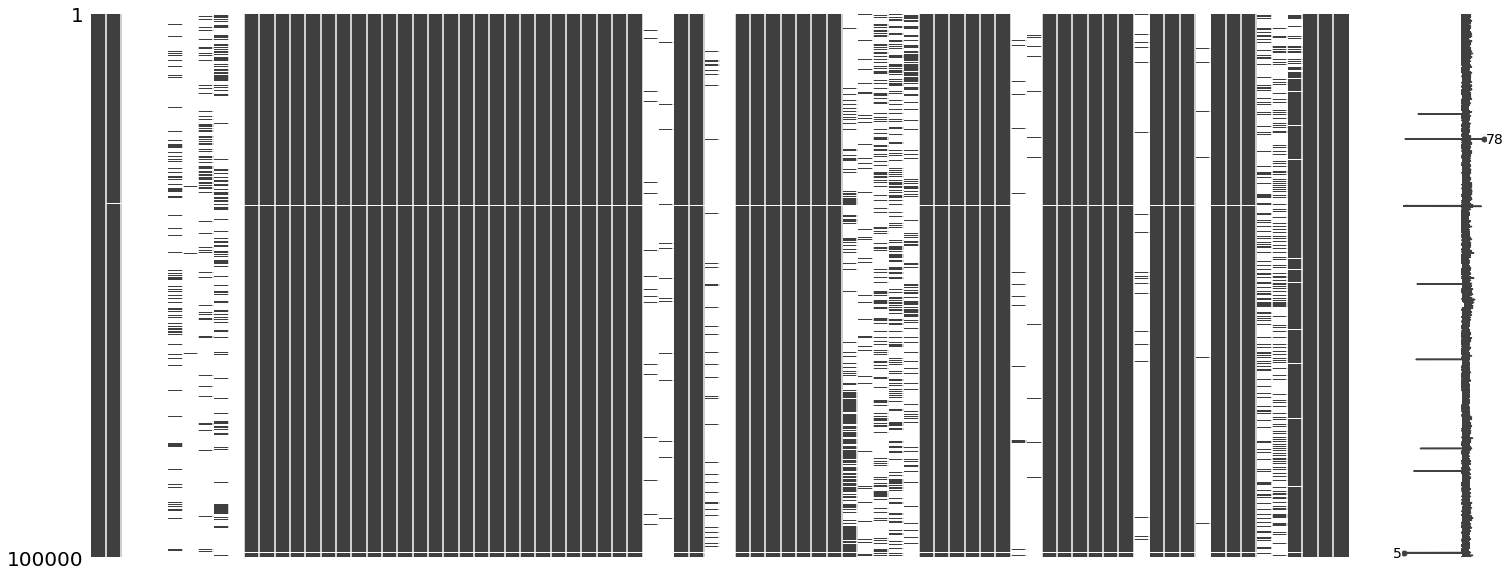

In [20]:
msno.matrix(test)

* имеются признаки которые есть в train а в test полностью отсутствуют 
* некоторое количество строк в тесте отстутствуют практически полностью, возможно была ошибка записи в бд

<AxesSubplot:>

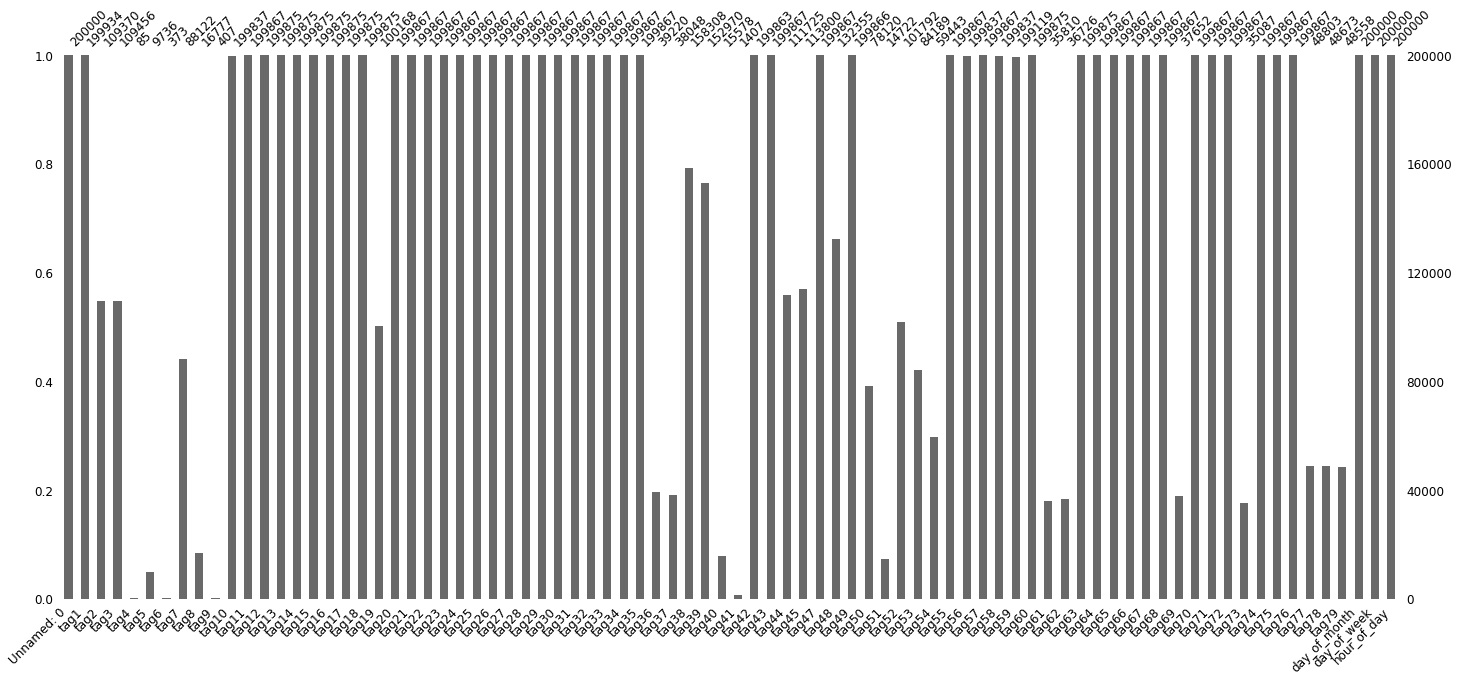

In [21]:
msno.bar(train.drop(['target1','target2', 'target3','target4'],1), labels=True ,fontsize = 12)

<AxesSubplot:>

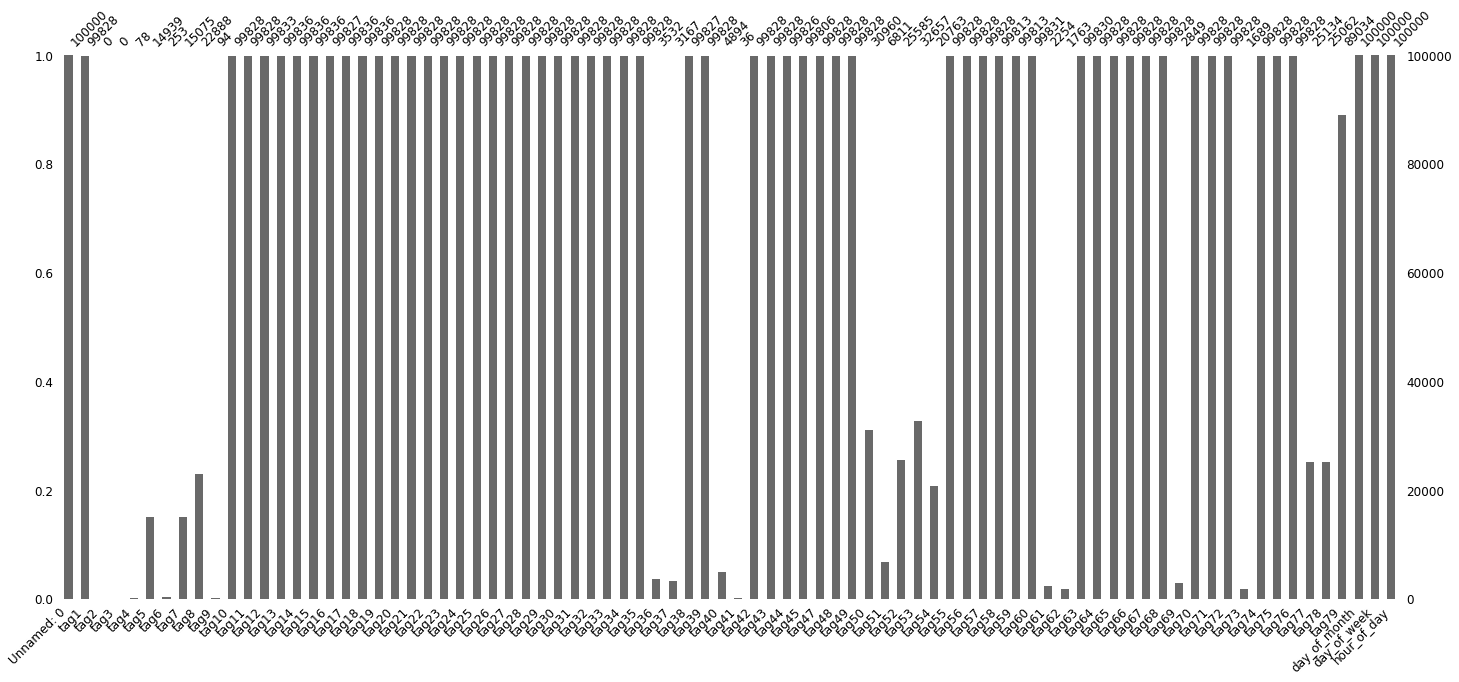

In [22]:
msno.bar(test, labels=True, fontsize = 12)

* стоит убрать признаки tag2- tag3 потому что в трейне имеются наблюдения по этим признакам а в тесте нет. 
* имеются признаки у которых мало наблюлений и в трейне и тесте , возможно это очень редкое наблюдение 

<a id='link_05'></a>
5. Корреляция между числовыми признаками

In [23]:
correlation = train.corr()
corr_with_target = correlation["target1"].sort_values(ascending = False)
corr_with_target.head()

target1    1.000000
target2    0.999999
tag49      0.527675
tag1       0.313592
tag5       0.295950
Name: target1, dtype: float64

In [24]:
corr_with_target.tail()

tag71     -0.339693
tag76     -0.362139
tag67     -0.506179
tag75     -0.551591
target3   -0.930867
Name: target1, dtype: float64

Text(0, 0.5, 'Density')

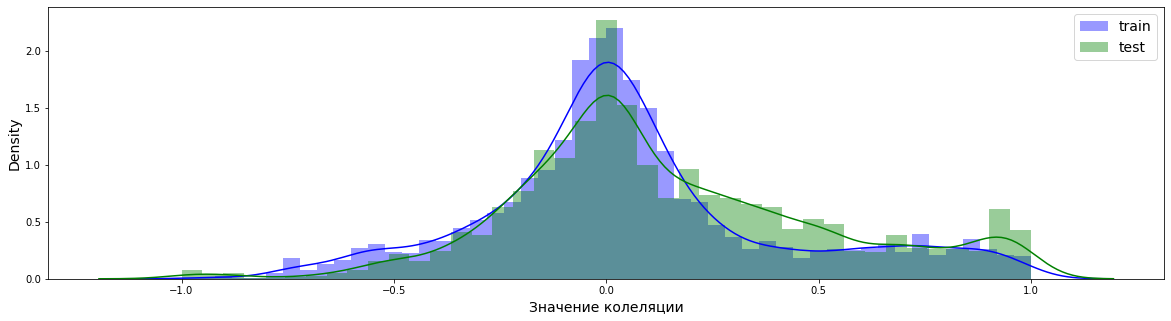

In [25]:
train_correlations = train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = train.drop(['target1', 'target2', 'target3','target4'],1).columns.tolist()


test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Значение колеляции", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

* имеются признаки с сильной линейной зависимостью
* так же имеется признаки с отрицательной линейной зависимостью

<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

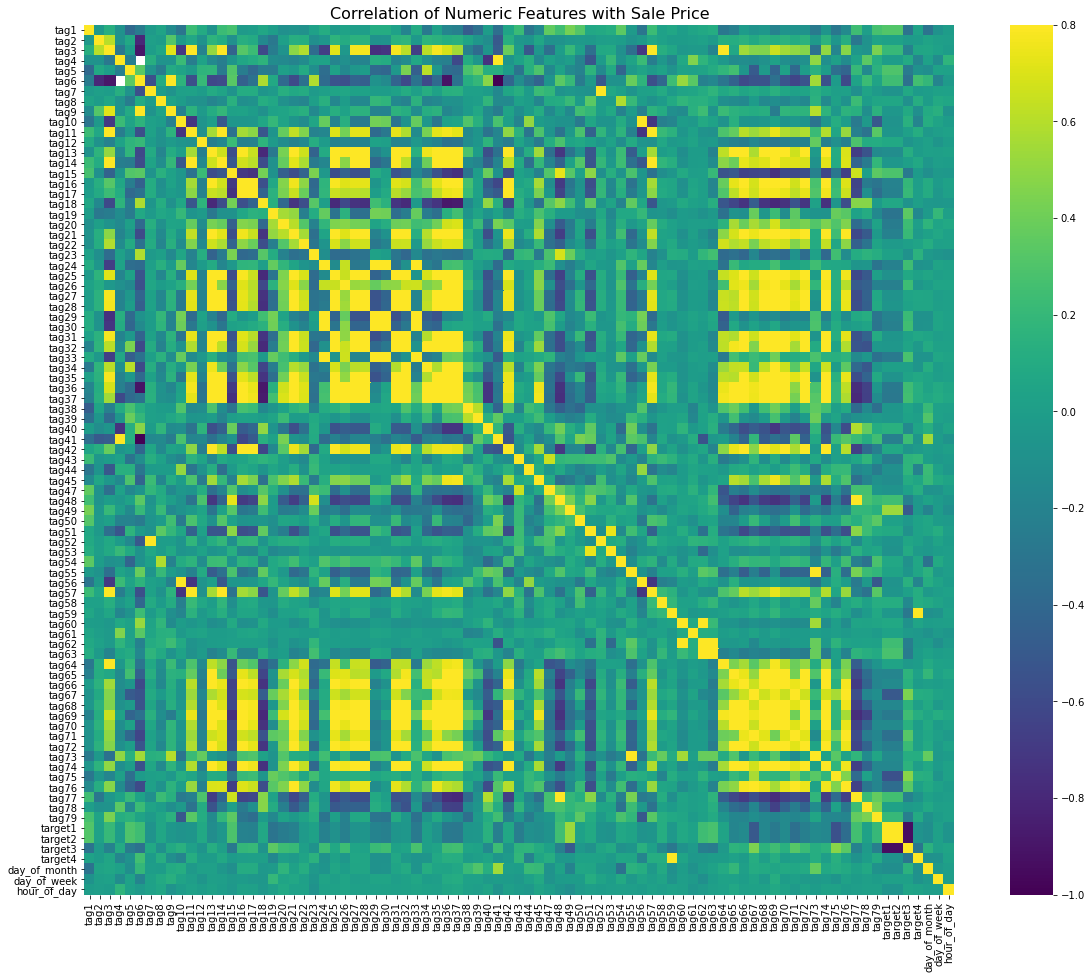

In [26]:
fig, axes = plt.subplots(figsize = (20,16))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

In [27]:
categorical_columns, continuous_columns = type_selector(train.drop(['target2', 'target3', 'target4', 'target1', 'Unnamed: 0','tag2', 'tag3',
                                                                    'tag69', 'tag54', 'tag57', 'tag5','tag35','tag36','tag37', 'tag31','tag33','tag29','tag28','tag14', 'tag15','tag17'
                                                                    ],1))

* target 1-target2 имеют сильную кореляцию друг с другом
* target3 имеет сильнуо обратную связь с target1-target2

<a id='link_06'></a>
6. Анализ распределения на обучении и тесте

Используя Adversarial Validation и не сложную модель в цикле будем убирать сильно отличающиеся по распределению признаки

In [28]:
cv = 1
features_to_score = train[categorical_columns+continuous_columns].columns.tolist()

In [29]:
%%time



while np.mean(cv) > 0.95:
    
    X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
                        ])
    y_adv = np.hstack(
        (np.ones(train.shape[0]), np.zeros(test.shape[0])))

    X_adv = X_adv.reset_index(drop=True)

    parameters = {
        "n_estimators": 22, "random_state": 27,"objective": "binary", "n_jobs": -1 }
    model = lgbm.LGBMClassifier(**parameters)
    
    model.fit(X_adv, y_adv)
    
    cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
    )

    print(f"CV-score: {round(np.mean(cv), 4)}")
    print(f"Колличество оставшихся признаков {len(features_to_score)}")

    importance = pd.DataFrame({
        "feature": X_adv.columns,
        "adversarial_importance": model.feature_importances_
                                })
    importance = importance.sort_values(by="adversarial_importance", ascending=False)
    importance = importance.head(n=100)
    
    features_to_score = importance[1:]
    features_to_score = features_to_score['feature'].tolist()
    
    

CV-score: 1.0
Колличество оставшихся признаков 65
CV-score: 1.0
Колличество оставшихся признаков 64
CV-score: 1.0
Колличество оставшихся признаков 63
CV-score: 1.0
Колличество оставшихся признаков 62
CV-score: 1.0
Колличество оставшихся признаков 61
CV-score: 1.0
Колличество оставшихся признаков 60
CV-score: 1.0
Колличество оставшихся признаков 59
CV-score: 1.0
Колличество оставшихся признаков 58
CV-score: 1.0
Колличество оставшихся признаков 57
CV-score: 0.9999
Колличество оставшихся признаков 56
CV-score: 0.9996
Колличество оставшихся признаков 55
CV-score: 0.9997
Колличество оставшихся признаков 54
CV-score: 0.9997
Колличество оставшихся признаков 53
CV-score: 0.9995
Колличество оставшихся признаков 52
CV-score: 0.9997
Колличество оставшихся признаков 51
CV-score: 0.9994
Колличество оставшихся признаков 50
CV-score: 0.9993
Колличество оставшихся признаков 49
CV-score: 0.9992
Колличество оставшихся признаков 48
CV-score: 0.9983
Колличество оставшихся признаков 47
CV-score: 0.9981
Кол

отделив признаки которые сильно отличаются на трейне от теста построим модель

In [30]:
features_to_score

['tag58',
 'tag77',
 'tag78',
 'tag55',
 'tag7',
 'tag8',
 'tag43',
 'tag52',
 'day_of_week',
 'tag62',
 'tag61',
 'tag73',
 'tag40',
 'hour_of_day',
 'tag53',
 'tag4',
 'tag41',
 'tag51',
 'tag9',
 'tag6']

<a id='link_07'></a>
7. Генерация признаков

In [31]:
def group_by_stat(df: pd.DataFrame ,features_list: list, feature: list) -> pd.DataFrame :
    
    """
    Генерация новых признаков на основе группировок по статистикам 
    df(pd.DataFrame) dataframe c данными
    features_list(list) список признаков которые будут группироваться 
    feature(list) признак по которому будет проводится группировка

    -----------------------------------------------------------------

    Return
        ---------
    pd.DataFrame с признаками на основе статистик
    
    """
    
    for item in features_list:
        df[item+"_mean"] = df.groupby(item)[feature].transform('mean')
        df[item+"_median"] = df.groupby(item)[feature].transform('median')
        df[item+"_std"] = df.groupby(item)[feature].transform('std')
        df[item+"_count"] = df.groupby(item)[feature].transform('count')
        df[item+"_min"] = df.groupby(item)[feature].transform('min')
        df[item+"_max"] = df.groupby(item)[feature].transform('max')
        df[item+"_summ"] = df.groupby(item)[feature].transform('sum')
    
    return df

In [32]:
def freq_encoder(df: pd.DataFrame, features_list: list) -> pd.DataFrame:
    
    """
    Генерация новых признаков на основе частоты появления значений в признаке
    df(pd.DataFrame) DataFrame c данными
    features_list(list) список признаков по которым генерироватся признаки
    
    --------------------------------------------------------------------------
    
    Return
        ---------
    pd.DataFrame с признаками на основе частот
    
    """
    
    for item in features_list:
        freq_encoder = df[item].value_counts(normalize=True)
        df[item+"_freq_enc"] = df[item].map(freq_encoder)
    
    return df

Применим функцию type_selector для признаков которые остались после Adversarial Validation 

In [33]:
categorical_columns, continuous_columns = type_selector(train[features_to_score])

Сгенерируем новые признаки при поможи функции freq_encoder

In [34]:
train_freq_encoder = freq_encoder(train[features_to_score], categorical_columns+continuous_columns)
test_freq_encoder = freq_encoder(test[features_to_score], categorical_columns+continuous_columns)


In [35]:
categorical_columns, continuous_columns = type_selector(train_freq_encoder)

Сгенерируем новые признаки на при помощи функции group_by_stat группировать будем по признакам day_of_week и hour_of_day

In [36]:
train_grouped_by_stat= group_by_stat(train_freq_encoder, categorical_columns+continuous_columns, 'day_of_week')
test_grouped_by_stat= group_by_stat(test_freq_encoder, categorical_columns+continuous_columns,'day_of_week')

In [37]:
train_grouped_by_stat= group_by_stat(train_grouped_by_stat, categorical_columns+continuous_columns, 'hour_of_day')
test_grouped_by_stat= group_by_stat(test_grouped_by_stat, categorical_columns+continuous_columns,'hour_of_day')

<a id='link_08'></a>
8. обучение моделей

<a id='link_09'></a>
8.1 Обучение модели для предказания target1

In [38]:
train_target_1 = train['target1'].drop(train.index[:9]).reset_index(drop=True) # так как в таргетах пропуски в первых 9 наблюдениях, берем все обучающие выборки начиная с 9 индекса
train_grouped_by_stat = train_grouped_by_stat.drop(train_grouped_by_stat.index[:9]).reset_index(drop=True)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train_grouped_by_stat, 
                                                    train_target_1, random_state=0)

In [40]:
model = lgbm.LGBMRegressor( max_depth=7,
                             learning_rate = 0.05,
                             random_state=42,
                             n_estimators=2500,
                             n_jobs= -1
                            
                                           )

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2',
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.714 +- 0.004


In [41]:
model.fit(train_grouped_by_stat,train_target_1 )

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=2500,
              random_state=42)

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

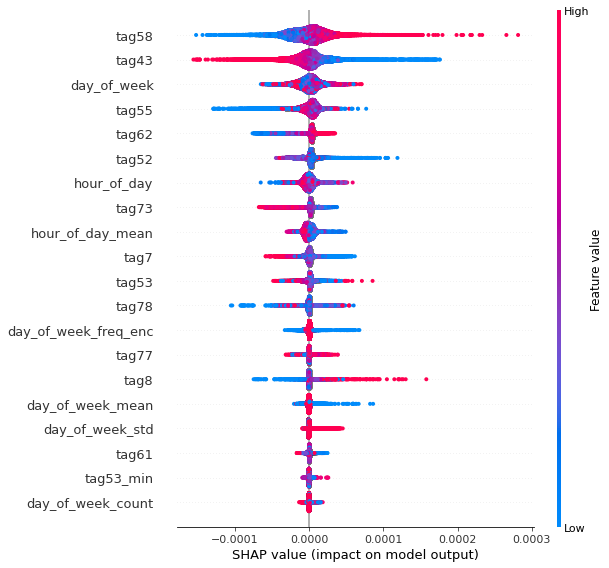

In [43]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=20, auto_size_plot=None)

In [44]:
vals= np.abs(shap_values).mean(0)

feature_importance_target1 = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance_target1.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance_target1['feature_importance_vals']

0      0.000018
6      0.000016
8      0.000010
3      0.000008
9      0.000007
         ...   
146    0.000000
147    0.000000
148    0.000000
149    0.000000
319    0.000000
Name: feature_importance_vals, Length: 320, dtype: float64

In [45]:
feature_importance_target1.head(10)

,col_name,feature_importance_vals
0,tag58,0.000018
6,tag43,0.000016
8,day_of_week,0.000010
3,tag55,0.000008
9,tag62,0.000007
7,tag52,0.000006
13,hour_of_day,0.000005
11,tag73,0.000005
47,hour_of_day_mean,0.000004
4,tag7,0.000003


In [46]:
predicted_target1 = model.predict(test_grouped_by_stat)

In [47]:
predicted_target1

array([0.00142022, 0.00144872, 0.0014692 , ..., 0.00118495, 0.00117935,
       0.00116854])

<a id='link_10'></a>
8.2 Обучение модели для предказания target2

In [48]:
train_target_2 = train['target2'].drop(train.index[:9]).reset_index(drop=True)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(train_grouped_by_stat, 
                                                    train_target_2, random_state=0)

In [50]:
model = lgbm.LGBMRegressor( max_depth=7,
                             learning_rate = 0.05,
                             random_state=42,
                             n_estimators=2500,
                             n_jobs= -1
                            
                                           )

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.714 +- 0.005


In [51]:
model.fit(train_grouped_by_stat,train_target_2 )

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=2500,
              random_state=42)

In [52]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

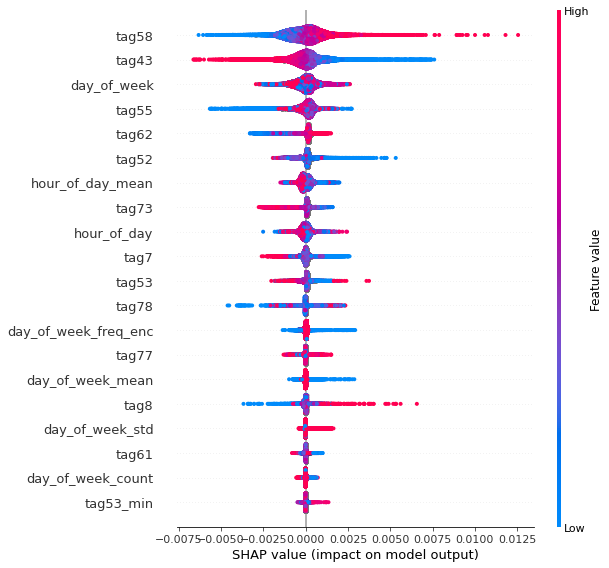

In [53]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=20, auto_size_plot=None)

In [54]:
vals= np.abs(shap_values).mean(0)

feature_importance_target2 = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance_target2.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance_target2['feature_importance_vals']

0      0.000781
6      0.000688
8      0.000433
3      0.000361
9      0.000315
         ...   
147    0.000000
148    0.000000
149    0.000000
150    0.000000
319    0.000000
Name: feature_importance_vals, Length: 320, dtype: float64

In [55]:
feature_importance_target2.head(10)


,col_name,feature_importance_vals
0,tag58,0.000781
6,tag43,0.000688
8,day_of_week,0.000433
3,tag55,0.000361
9,tag62,0.000315
7,tag52,0.000261
47,hour_of_day_mean,0.000205
11,tag73,0.000195
13,hour_of_day,0.000187
4,tag7,0.000144


In [56]:
predicted_target2 = model.predict(test_grouped_by_stat)

<a id='link_11'></a>
8.3 Обучение модели для предказания target3

In [57]:
train_target_3 = train['target3'].drop(train.index[:9]).reset_index(drop=True)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(train_grouped_by_stat, 
                                                    train_target_3, random_state=0)

In [59]:
model = lgbm.LGBMRegressor( max_depth=7,
                             learning_rate = 0.05,
                             random_state=42,
                             n_estimators=2500,
                             n_jobs= -1
                            
                                           )

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.704 +- 0.002


In [60]:
model.fit(train_grouped_by_stat,train_target_3 )

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=2500,
              random_state=42)

In [61]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

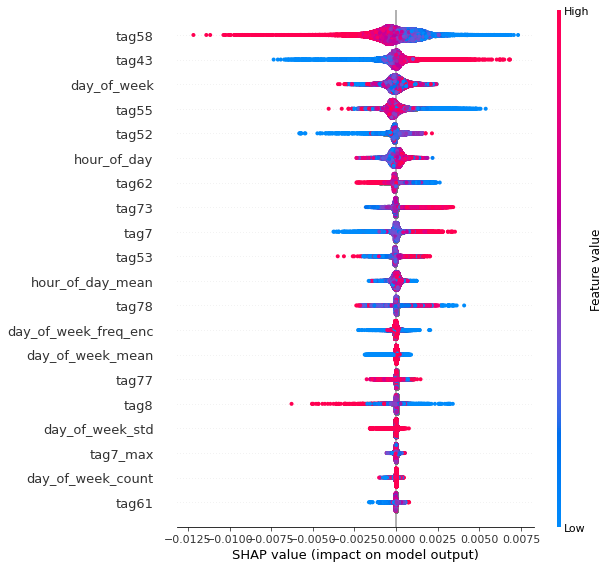

In [62]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=20, auto_size_plot=None)

In [63]:
vals= np.abs(shap_values).mean(0)

feature_importance_target3 = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance_target3.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance_target3['feature_importance_vals']

0      0.000986
6      0.000528
8      0.000397
3      0.000383
7      0.000265
         ...   
147    0.000000
148    0.000000
149    0.000000
150    0.000000
319    0.000000
Name: feature_importance_vals, Length: 320, dtype: float64

In [64]:
feature_importance_target3.head(10)

,col_name,feature_importance_vals
0,tag58,0.000986
6,tag43,0.000528
8,day_of_week,0.000397
3,tag55,0.000383
7,tag52,0.000265
13,hour_of_day,0.000250
9,tag62,0.000219
11,tag73,0.000195
4,tag7,0.000172
14,tag53,0.000143


In [65]:
predicted_target3 = model.predict(test_grouped_by_stat)

<a id='link_12'></a>
8.4 Обучение модели для предказания target4

In [66]:
train_target_4 = train['target4'].drop(train.index[:9]).reset_index(drop=True)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(train_grouped_by_stat, 
                                                    train_target_4, random_state=0)

In [68]:
model = lgbm.LGBMRegressor( max_depth=7,
                             learning_rate = 0.05,
                             random_state=42,
                             n_estimators=2500,
                             n_jobs= -1
                            
                                           )

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.741 +- 0.006


In [69]:
model.fit(train_grouped_by_stat,train_target_4 )

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=2500,
              random_state=42)

In [70]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

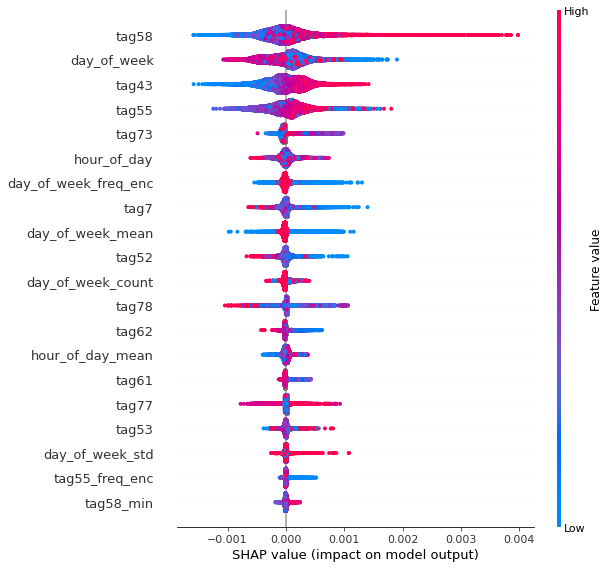

In [71]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=20, auto_size_plot=None)

In [72]:
vals= np.abs(shap_values).mean(0)

feature_importance_target4 = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance_target4.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance_target4['feature_importance_vals']

0      0.000262
8      0.000251
6      0.000237
3      0.000229
11     0.000106
         ...   
148    0.000000
149    0.000000
150    0.000000
151    0.000000
319    0.000000
Name: feature_importance_vals, Length: 320, dtype: float64

In [73]:
feature_importance_target4.head(10)

,col_name,feature_importance_vals
0,tag58,0.000262
8,day_of_week,0.000251
6,tag43,0.000237
3,tag55,0.000229
11,tag73,0.000106
13,hour_of_day,0.000065
20,day_of_week_freq_enc,0.000051
40,day_of_week_mean,0.000051
4,tag7,0.000050
7,tag52,0.000049


In [74]:
predicted_target4 = model.predict(test_grouped_by_stat)

In [75]:
predicted_target4

array([0.00407741, 0.00460421, 0.00420182, ..., 0.00799802, 0.00670916,
       0.00794992])

In [80]:
preds_final = pd.DataFrame()
preds_final['target1_pred'] = predicted_target1.copy()
preds_final['target2_pred'] = predicted_target2.copy()
preds_final['target3_pred'] = predicted_target3.copy()
preds_final['target4_pred'] = predicted_target4.copy()

In [81]:
preds_final

,target1_pred,target2_pred,target3_pred,target4_pred
0,0.001420,0.061811,0.930102,0.004077
1,0.001449,0.062334,0.928659,0.004604
2,0.001469,0.061180,0.930887,0.004202
3,0.001495,0.063388,0.928227,0.004274
4,0.001289,0.054223,0.938502,0.005709
...,...,...,...,...
99995,0.001138,0.049260,0.941309,0.008084
99996,0.001166,0.050020,0.942215,0.006491
99997,0.001185,0.051070,0.940667,0.007998
99998,0.001179,0.050844,0.941288,0.006709


In [82]:
feature_importance_targets = pd.DataFrame()
feature_importance_targets['feature_importance_target1'] = feature_importance_target1['col_name'].copy()
feature_importance_targets['feature_importance_target2'] = feature_importance_target2['col_name'].copy()
feature_importance_targets['feature_importance_target3'] = feature_importance_target3['col_name'].copy()
feature_importance_targets['feature_importance_target4'] = feature_importance_target4['col_name'].copy()

In [85]:
feature_importance_targets.head(10)

,feature_importance_target1,feature_importance_target2,feature_importance_target3,feature_importance_target4
0,tag58,tag58,tag58,tag58
6,tag43,tag43,tag43,tag43
8,day_of_week,day_of_week,day_of_week,day_of_week
3,tag55,tag55,tag55,tag55
9,tag62,tag62,tag62,tag62
7,tag52,tag52,tag52,tag52
13,hour_of_day,hour_of_day,hour_of_day,hour_of_day
11,tag73,tag73,tag73,tag73
47,hour_of_day_mean,hour_of_day_mean,hour_of_day_mean,hour_of_day_mean
4,tag7,tag7,tag7,tag7


In [86]:
preds_final.to_csv('predictions.csv', index=False)
feature_importance_targets.to_csv('feature_importance_targets.csv', index=False)
